## Fake Data and Modelling Utility

In [68]:
import pymc as pm
import numpy as np
import pandas as pd
import pytensor.tensor as pt 
import arviz as az
from collections import OrderedDict    # For recording the model specification 

import pandas as pd                    # For file input/output
import numpy as np                     # For vectorized math operations

import pylogit as pl    


In [74]:
wide_heating_df = pd.read_csv('../data/heating_data_r.csv')
wide_heating_df[wide_heating_df['idcase'] == 1]

,idcase,depvar,ic.gc,ic.gr,ic.ec,ic.er,ic.hp,oc.gc,oc.gr,oc.ec,oc.er,oc.hp,income,agehed,rooms,region
0,1,gc,866.0,962.64,859.9,995.76,1135.5,199.69,151.72,553.34,505.6,237.88,7,25,6,ncostl


In [73]:
long_heating_df = pd.read_csv('../data/long_heating_data.csv')
long_heating_df[long_heating_df['idcase'] == 1]

,Unnamed: 0,idcase,alt_id,choice,depvar,income,agehed,rooms,region,installation_costs,operating_costs
0,0,1,1,1,gc,7,25,6,ncostl,866.00,199.69
1,1,1,2,0,gc,7,25,6,ncostl,962.64,151.72
2,2,1,3,0,gc,7,25,6,ncostl,859.90,553.34
3,3,1,4,0,gc,7,25,6,ncostl,995.76,505.60
4,4,1,5,0,gc,7,25,6,ncostl,1135.50,237.88


/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pytensor/tensor/special.py:491: FutureWarning: Softmax now accepts an axis argument. For backwards-compatibility it defaults to -1 when not specified, but in the future the default will be `None`.
To suppress this warning specify axis explicitly.
  warnings.warn(
Sampling: [alpha, beta_ic, beta_oc, y_cat]
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.481050
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:15.198636
Transforming variables...


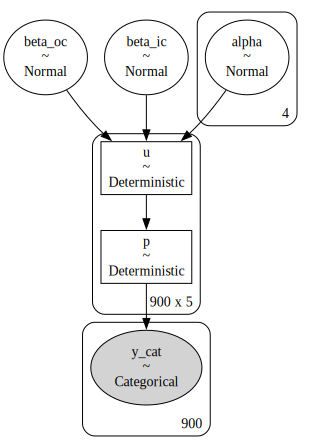

In [180]:
N = wide_heating_df.shape[0]
observed = pd.Categorical(wide_heating_df['depvar']).codes
#observed = pd.get_dummies(wide_heating_df['depvar'])
#observed = long_heating_df['choice']


with pm.Model() as model:
    beta_ic = pm.Normal('beta_ic', 0, 1)
    beta_oc = pm.Normal('beta_oc', 0, 1)
    alphas = pm.Normal('alpha', 0, 1, shape=4)

    u0 = alphas[0] + beta_ic * wide_heating_df['ic.ec'] + beta_oc*wide_heating_df['oc.ec']
    u1 = alphas[1] + beta_ic * wide_heating_df['ic.er'] + beta_oc*wide_heating_df['oc.er']
    u2 = alphas[2] + beta_ic * wide_heating_df['ic.gc'] + beta_oc*wide_heating_df['oc.gc']
    u3 = alphas[3] + beta_ic * wide_heating_df['ic.gr'] + beta_oc*wide_heating_df['oc.gr']
    u4 = np.zeros(N)  # pivot
    s = pm.Deterministic('u', pm.math.stack([u0, u1, u2, u3, u4]).T)

    p_ = pm.Deterministic('p', pt.special.softmax(s))
    choice_obs = pm.Categorical('y_cat', p=p_, observed=observed)
    #choice_obs = pm.Multinomial('y_cat', n=1, p=p_, observed=observed)

    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(nuts_sampler='numpyro'))
    idata.extend(pm.sample_posterior_predictive(idata))


pm.model_to_graphviz(model)

    


In [181]:
az.summary(idata, var_names=['beta_ic', 'beta_oc', 'alpha'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_ic,0.001,0.001,-0.000,0.002,0.000,0.000,931.0,1471.0,1.00
beta_oc,-0.003,0.001,-0.005,-0.001,0.000,0.000,1280.0,1395.0,1.00
alpha[0],1.037,0.519,0.045,1.964,0.017,0.012,924.0,1165.0,1.00
alpha[1],1.077,0.497,0.131,1.970,0.017,0.012,877.0,1164.0,1.01
alpha[2],2.372,0.333,1.783,3.030,0.012,0.008,786.0,974.0,1.01
alpha[3],0.729,0.403,-0.007,1.493,0.014,0.010,788.0,1077.0,1.01


<Axes: xlabel='y_cat / y_cat'>

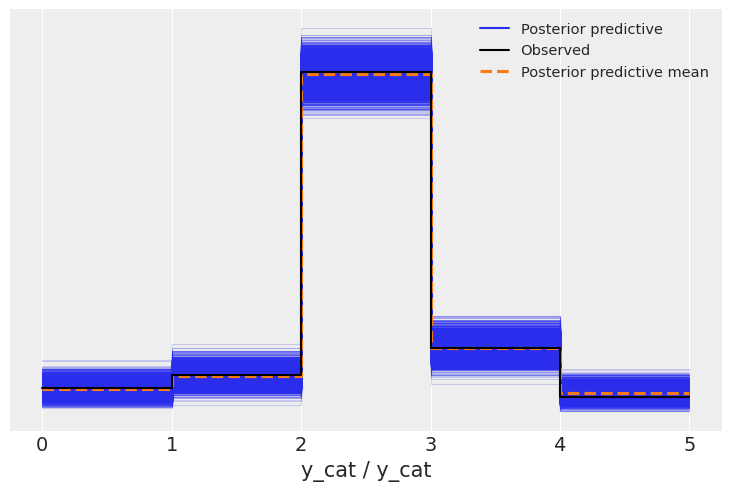

In [182]:
az.plot_ppc(idata)

In [145]:
import arviz as az
import bambi as bmb
import numpy as np
import pandas as pd

from formulae import design_matrices

az.style.use("arviz-darkgrid")

rng = np.random.default_rng(0)

def c(*args):
    return np.column_stack(args)

n = 15
size = 10
data = pd.DataFrame(
    {
        "y1": rng.binomial(n, 0.3, size),
        "y2": rng.binomial(n, 0.5, size),
        "y3": rng.binomial(n, 0.7, size),
        "x": rng.normal(size=size)
    }
)

dm = design_matrices("c(y1, y2, y3) ~ x", data)
Y = dm.response.design_matrix
X = dm.common.design_matrix

In [167]:
observed

,ec,er,gc,gr,hp
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,1,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
895,0,0,1,0,0
896,0,0,1,0,0
897,0,0,1,0,0
898,0,0,1,0,0


In [146]:
Y

array([[ 5,  9, 14],
       [ 3,  2, 13],
       [ 2, 10, 10],
       [ 1,  4, 10],
       [ 6,  9, 10],
       [ 7,  6, 11],
       [ 5, 10,  5],
       [ 6,  8,  7],
       [ 5,  6, 10],
       [ 7,  7, 10]])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


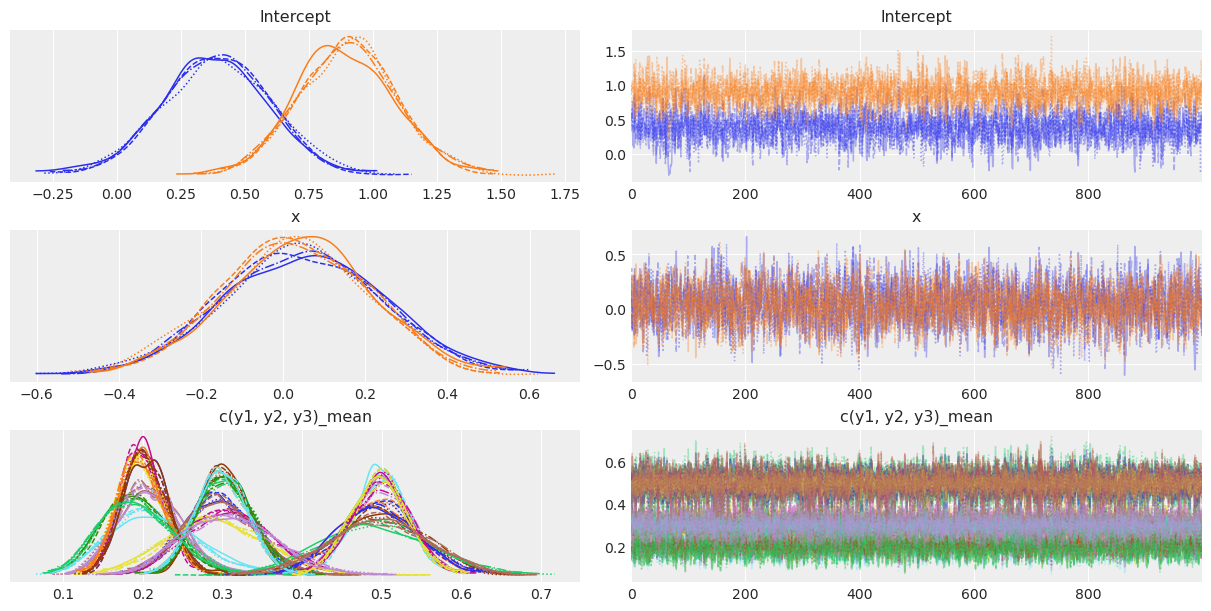

In [151]:
def c(*args):
    return np.column_stack(args)

n = 15
size = 10
data = pd.DataFrame(
    {
        "y1": rng.binomial(n, 0.3, size),
        "y2": rng.binomial(n, 0.5, size),
        "y3": rng.binomial(n, 0.7, size),
        "x": rng.normal(size=size)
    }
)

bmb_model = bmb.Model("c(y1, y2, y3) ~ x", data, family="multinomial")
idata = bmb_model.fit(random_seed=0)

bmb_model.predict(idata)
az.plot_trace(idata);